Ratings DataFrame:
   book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4

Books DataFrame:
   book_id                                              title
0  2767052            The Hunger Games (The Hunger Games, #1)
1        3  Harry Potter and the Sorcerer's Stone (Harry P...
2    41865                            Twilight (Twilight, #1)
3     2657                              To Kill a Mockingbird
4     4671                                   The Great Gatsby


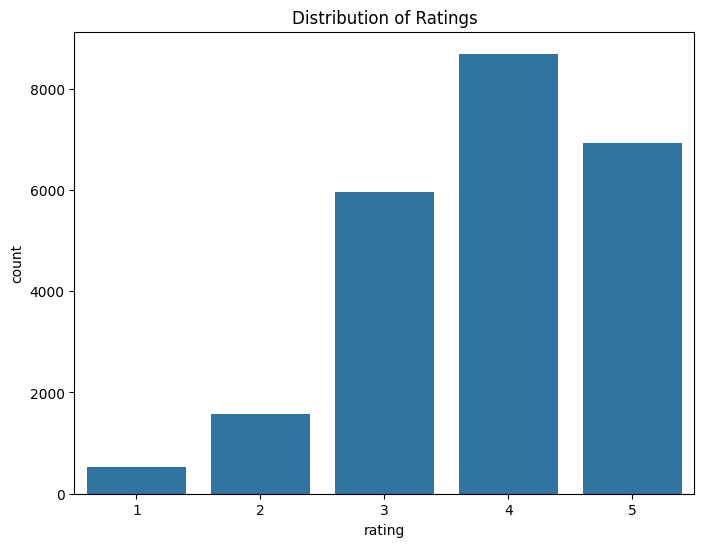

Top 5 users with most ratings:
user_id
23612    19
42404    15
3922     14
18361    14
33716    14
Name: rating, dtype: int64
Epoch: 1/10, Training Loss: 45.1293, Validation Loss: 46.1254
Epoch: 2/10, Training Loss: 42.4413, Validation Loss: 45.7255
Epoch: 3/10, Training Loss: 39.8966, Validation Loss: 45.3435
Epoch: 4/10, Training Loss: 37.4908, Validation Loss: 44.9805
Epoch: 5/10, Training Loss: 35.2187, Validation Loss: 44.6362
Epoch: 6/10, Training Loss: 33.0747, Validation Loss: 44.3107
Epoch: 7/10, Training Loss: 31.0531, Validation Loss: 44.0040
Epoch: 8/10, Training Loss: 29.1481, Validation Loss: 43.7160
Epoch: 9/10, Training Loss: 27.3540, Validation Loss: 43.4465
Epoch: 10/10, Training Loss: 25.6648, Validation Loss: 43.1953
Training RMSE: 4.9066
Validation RMSE: 6.5723
Recommendations for User 314:
     book_id                                              title  \
53        11  The Hitchhiker's Guide to the Galaxy (Hitchhik...   
248     4588                Extremely Loud 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split

# Load the datasets
books = pd.read_csv('datasets/books.csv', encoding='utf-8')
ratings = pd.read_csv('datasets/ratings.csv')

# Limit to the first 1000 books
books = books.head(1000)
book_ids = books['book_id'].tolist()

# Filter ratings to include only the selected books
ratings = ratings[ratings['book_id'].isin(book_ids)]

# Reset indices
ratings.reset_index(drop=True, inplace=True)

# Overview of the ratings dataset
print("Ratings DataFrame:")
print(ratings.head())

# Overview of the books dataset
print("\nBooks DataFrame:")
print(books[['book_id', 'title']].head())

# Distribution of ratings
plt.figure(figsize=(8,6))
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.show()

# Number of ratings per user
ratings_per_user = ratings.groupby('user_id')['rating'].count().sort_values(ascending=False)
print("Top 5 users with most ratings:")
print(ratings_per_user.head())

# Create user and item mappings
user_ids = ratings['user_id'].unique()
book_ids = ratings['book_id'].unique()

user2idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
book2idx = {book_id: idx for idx, book_id in enumerate(book_ids)}

# Map the user IDs and book IDs to indices
ratings['user_idx'] = ratings['user_id'].map(user2idx)
ratings['book_idx'] = ratings['book_id'].map(book2idx)

# Prepare training and validation sets
train_data, val_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_users = torch.tensor(train_data['user_idx'].values, dtype=torch.long)
train_books = torch.tensor(train_data['book_idx'].values, dtype=torch.long)
train_ratings = torch.tensor(train_data['rating'].values, dtype=torch.float)

val_users = torch.tensor(val_data['user_idx'].values, dtype=torch.long)
val_books = torch.tensor(val_data['book_idx'].values, dtype=torch.long)
val_ratings = torch.tensor(val_data['rating'].values, dtype=torch.float)

# Define the Recommender Model
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=50):
        super(MatrixFactorization, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)
        
    def forward(self, user_indices, item_indices):
        user_vectors = self.user_embedding(user_indices)
        item_vectors = self.item_embedding(item_indices)
        return (user_vectors * item_vectors).sum(1)

# Hyperparameters
num_users = len(user2idx)
num_items = len(book2idx)
embedding_size = 30
epochs = 10
learning_rate = 0.01

# Initialize the model, loss function, and optimizer
model = MatrixFactorization(num_users, num_items, embedding_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    predictions = model(train_users, train_books)
    loss = criterion(predictions, train_ratings)
    
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_predictions = model(val_users, val_books)
        val_loss = criterion(val_predictions, val_ratings)
    
    print(f"Epoch: {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

# Model Evaluation
def get_rmse(model, users, items, ratings):
    model.eval()
    with torch.no_grad():
        predictions = model(users, items)
        mse = criterion(predictions, ratings)
        rmse = torch.sqrt(mse)
    return rmse.item()

train_rmse = get_rmse(model, train_users, train_books, train_ratings)
val_rmse = get_rmse(model, val_users, val_books, val_ratings)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")

# Generating Recommendations
def recommend_books(model, user_id, user2idx, book2idx, books_df, num_recommendations=5):
    model.eval()
    user_idx = torch.tensor([user2idx[user_id]], dtype=torch.long)
    
    # Get all book indices
    all_book_indices = torch.tensor(list(book2idx.values()), dtype=torch.long)
    
    # Predict ratings for all books
    with torch.no_grad():
        ratings_pred = model(user_idx.repeat(len(all_book_indices)), all_book_indices)
    
    # Get top N recommendations
    top_indices = torch.topk(ratings_pred, num_recommendations).indices.numpy()
    recommended_book_indices = all_book_indices[top_indices].numpy()
    
    # Map indices back to book IDs
    idx2book = {idx: book_id for book_id, idx in book2idx.items()}
    recommended_book_ids = [idx2book[idx] for idx in recommended_book_indices]
    
    # Get book titles
    recommended_books = books_df[books_df['book_id'].isin(recommended_book_ids)]
    
    return recommended_books[['book_id', 'title', 'authors']]

# Recommendations for User 1
user_id_1 = ratings['user_id'].iloc[0]  # Assuming user_id exists
print(f"Recommendations for User {user_id_1}:")
recs_user1 = recommend_books(model, user_id_1, user2idx, book2idx, books)
print(recs_user1)

# Recommendations for User 50
user_id_50 = ratings['user_id'].iloc[50]  # Assuming user_id exists
print(f"Recommendations for User {user_id_50}:")
recs_user50 = recommend_books(model, user_id_50, user2idx, book2idx, books)
print(recs_user50)

# Analysis of Recommendations
print("Books recommended to User 1 that are not recommended to User 50:")
diff_books = recs_user1[~recs_user1['book_id'].isin(recs_user50['book_id'])]
print(diff_books)

print("Books recommended to User 50 that are not recommended to User 1:")
diff_books = recs_user50[~recs_user50['book_id'].isin(recs_user1['book_id'])]
print(diff_books)
